In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import random

import warnings
warnings.filterwarnings("ignore")

## Baseline

In [4]:
train = pd.read_csv('./data/train/train.csv')

In [5]:
submission = pd.read_csv('./data/sample_submission.csv')

In [6]:
# data를 넣어주면 
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']] # day, minute, 

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')   # 뒤에서 48개의 값을 지우고 가장 마지막 값으로 채운다
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill') # 뒤에서 96개의 값을 지우고 가장 마지막 값으로 채운다
        temp = temp.dropna()  # 결측치 제거
        
        return temp.iloc[:-96] # 아 이건 예측값이 0이 되버리니까 제거해버리는구나 ㅇㅋㅇㅋ

    elif is_train==False:
        
        temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]
df_train = preprocess_data(train)

# RH(상대 습도)

In [7]:
def RH_2(df_train):
    df_train['new_RH']=0
    # RH가 ~20 사이, 20~40 사이, 40~60, 60~80, ~100
    df_train.loc[df_train['RH']<30,'new_RH'] = 0
    df_train.loc[(30<=df_train['RH']) & (df_train['RH']<60),'new_RH'] = 1
    df_train.loc[60<=df_train['RH'],'new_RH'] = 2
    return df_train

# WS(풍속)

In [8]:
def WS_3(df_train):
    df_train['new_WS']=0
    df_train.loc[df_train['WS']<1.5,'new_RH'] = 0
    df_train.loc[(1.5<=df_train['WS']) & (df_train['WS']<4),'new_WS'] = 1
    df_train.loc[(4<=df_train['WS']) & (df_train['WS']<6),'new_WS'] = 2
    df_train.loc[6<=df_train['WS'],'new_WS'] = 3
    return df_train

# DNI, DHI를 계산해서 GHI 계산

In [9]:
def cal_ghi(df):
    df['GHI']=0
    lst = list(df.columns)
    idx_hour = lst.index('Hour')
    idx_dhi = lst.index('DHI')
    idx_dni = lst.index('DNI')
    idx_ghi = lst.index('GHI')
    for i in range(len(df)):
        hour = df.iloc[i,idx_hour]
        if 8 <= hour <= 16:
            degree = (hour-7) * np.pi/18
            GHI = df.iloc[i,idx_dni] + df.iloc[i,idx_dhi]*(np.cos(90-degree))  # DHI +DNI*cos(Θ)
            if GHI<0:
                GHI=0
            df.iloc[i,idx_ghi] = GHI
    return df

# Temperature

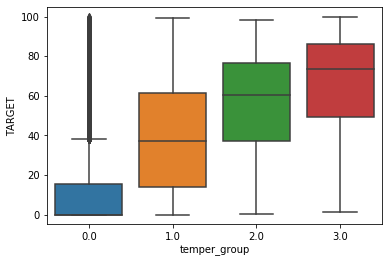

In [10]:
def temperature(temp_target):
    temp_target.loc[temp_target['T']<0,'temper_group'] = 0
    temp_target.loc[(0<= temp_target['T']) &(temp_target['T'] < 20),'temper_group'] = 0
    temp_target.loc[(20<= temp_target['T']) &(temp_target['T'] < 25),'temper_group'] = 1
    temp_target.loc[(25<= temp_target['T']) &(temp_target['T'] < 30),'temper_group'] = 2
    temp_target.loc[30 <= temp_target['T'],'temper_group'] = 3
    return temp_target
sns.boxplot(x='temper_group',y='TARGET',data=temperature(df_train))

# max_temp_day
- 그 날의 최고기온 

In [11]:
def max_temp(df):
    a = []
    for i in range(0,len(df),48):
        temp = df[i:i+48]
        max_val = temp['T'].max()
        temp['max'] = max_val
        a.append(temp)
    dfdf = pd.concat(a)
    return dfdf

In [13]:
df_train = max_temp(df_train)

# day_temp/Whole_temp
- 계절에 대한 힌트 정도

In [16]:
def max_temp(df):
    a = []
    for i in range(0,len(df),48):
        temp = df[i:i+48]
        max_val = temp['T'].max()
        temp['max'] = max_val
        a.append(temp)
    dfdf = pd.concat(a)
    return dfdf
def ratio_temp(df):
    df = max_temp(df)
    max_val = df['T'].max()
    df['ratio_temp'] =  df['max']/max_val
    return df

In [15]:
ratio_temp(df_train)

,Hour,TARGET,DHI,DNI,WS,RH,T,Target1,Target2,temper_group,max,ratio_temp
0,0,0.0,0,0,1.5,69.08,-12,0.0,0.0,0.0,-3,-0.085714
1,0,0.0,0,0,1.5,69.06,-12,0.0,0.0,0.0,-3,-0.085714
2,1,0.0,0,0,1.6,71.78,-12,0.0,0.0,0.0,-3,-0.085714
3,1,0.0,0,0,1.6,71.75,-12,0.0,0.0,0.0,-3,-0.085714
4,2,0.0,0,0,1.6,75.20,-12,0.0,0.0,0.0,-3,-0.085714
...,...,...,...,...,...,...,...,...,...,...,...,...
52459,21,0.0,0,0,3.5,55.97,-1,0.0,0.0,0.0,9,0.257143
52460,22,0.0,0,0,3.9,54.23,-2,0.0,0.0,0.0,9,0.257143
52461,22,0.0,0,0,4.1,54.21,-2,0.0,0.0,0.0,9,0.257143
52462,23,0.0,0,0,4.3,56.46,-2,0.0,0.0,0.0,9,0.257143


In [17]:
df_train = cal_ghi(df_train)
df_train = RH_2(df_train)
df_train = WS_3(df_train)
df_train = temperature(df_train)
df_train = ratio_temp(df_train)

In [21]:
df_train

,Hour,TARGET,DHI,DNI,WS,RH,T,Target1,Target2,temper_group,max,ratio_temp,GHI,new_RH,new_WS
0,0,0.0,0,0,1.5,69.08,-12,0.0,0.0,0.0,-3,-0.085714,0.0,2,1
1,0,0.0,0,0,1.5,69.06,-12,0.0,0.0,0.0,-3,-0.085714,0.0,2,1
2,1,0.0,0,0,1.6,71.78,-12,0.0,0.0,0.0,-3,-0.085714,0.0,2,1
3,1,0.0,0,0,1.6,71.75,-12,0.0,0.0,0.0,-3,-0.085714,0.0,2,1
4,2,0.0,0,0,1.6,75.20,-12,0.0,0.0,0.0,-3,-0.085714,0.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52459,21,0.0,0,0,3.5,55.97,-1,0.0,0.0,0.0,9,0.257143,0.0,1,1
52460,22,0.0,0,0,3.9,54.23,-2,0.0,0.0,0.0,9,0.257143,0.0,1,1
52461,22,0.0,0,0,4.1,54.21,-2,0.0,0.0,0.0,9,0.257143,0.0,1,2
52462,23,0.0,0,0,4.3,56.46,-2,0.0,0.0,0.0,9,0.257143,0.0,1,2


In [20]:
# ['Hour', 'TARGET', 'DHI', 'DNI','RH', 'T', 'ratio_temp', 'GHI', 'new_RH', 'new_WS', 'Target1', 'Target2']
df_train.columns

Index(['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T', 'Target1', 'Target2',
       'temper_group', 'max', 'ratio_temp', 'GHI', 'new_RH', 'new_WS'],
      dtype='object')

In [29]:
df_train= df_train[['Hour', 'TARGET', 'DHI', 'DNI','RH', 'T', 'ratio_temp', 'GHI', 'new_WS', 'Target1', 'Target2']]

In [24]:
df_test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, is_train=False)
    df_test.append(temp)

X_test = pd.concat(df_test)
X_test.shape

(3888, 7)

In [25]:
X_test = cal_ghi(X_test)
X_test = RH_2(X_test)
X_test = WS_3(X_test)
X_test = temperature(X_test)
X_test = ratio_temp(X_test)

In [30]:
X_test = X_test[['Hour', 'TARGET', 'DHI', 'DNI','RH', 'T', 'ratio_temp', 'GHI', 'new_WS']]

In [31]:
from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -2], test_size=0.3, random_state=0)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -1], test_size=0.3, random_state=0)

In [32]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [33]:
from lightgbm import LGBMRegressor

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [34]:
# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred

In [35]:
# Target1
models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test)
results_1.sort_index()[:48]

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.36433
Early stopping, best iteration is:
[332]	valid_0's quantile: 1.35939
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.17132
[1000]	valid_0's quantile: 2.16229
Early stopping, best iteration is:
[804]	valid_0's quantile: 2.15875
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.55072
[1000]	valid_0's quantile: 2.52791
[1500]	valid_0's quantile: 2.51309
[2000]	valid_0's quantile: 2.50615
[2500]	valid_0's quantile: 2.50041
[3000]	valid_0's quantile: 2.49567
[

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [36]:
# Target2
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test)
results_2.sort_index()[:48]

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.36704
[1000]	valid_0's quantile: 1.36036
Early stopping, best iteration is:
[1112]	valid_0's quantile: 1.36019
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.17931
Early stopping, best iteration is:
[411]	valid_0's quantile: 2.17174
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.56928
[1000]	valid_0's quantile: 2.53305
[1500]	valid_0's quantile: 2.52715
Early stopping, best iteration is:
[1267]	valid_0's quantile: 2.52639
0.4
[LightGBM] [Warning] bagging_fr

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [37]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
submission.to_csv('./data/day_whole.csv', index=False)

In [41]:
y = models_1[3].feature_importances_
label = models_1[3].feature_name_

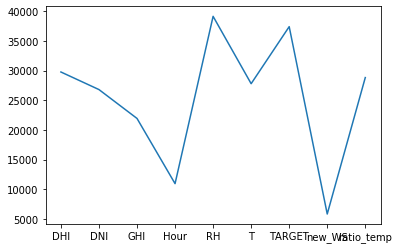

In [42]:
# drop 전
y = models_1[3].feature_importances_
label = models_1[3].feature_name_
sns.lineplot(x = label, y = y)

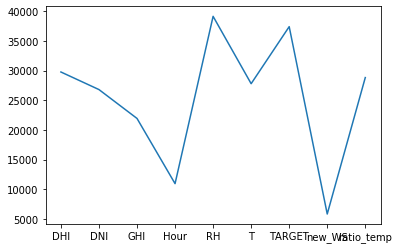

In [43]:
# WS RH drop
y = models_1[3].feature_importances_
label = models_1[3].feature_name_
sns.lineplot(x = label, y = y)

In [91]:
# weather, new_RH, temper_group drop
label

['Hour',
 'TARGET',
 'DHI',
 'DNI',
 'T',
 'GHI',
 'temper_group',
 'new_RH',
 'new_WS',
 'Weather']